1. Create function that given an image of a Sudoku game crops and extracts each cell 
1. Extract the number from each cropped cell (if blank extract it as 0)
1. Place the extracted numbers in an array (each block of 9 numbers is one array)
1. Apply the sudoku solver to the array to get the solution
1. Write the solution numbers in the cells

In [1]:
import cv2
import imutils
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

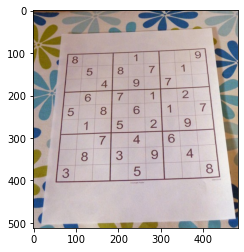

In [2]:
sudoku = cv2.imread("./img/sudoku3.jpeg")
sudoku_gray = cv2.cvtColor(sudoku, cv2.COLOR_BGR2GRAY)
sudoku_color = cv2.cvtColor(sudoku, cv2.COLOR_BGR2RGB)
plt.imshow(sudoku_color);

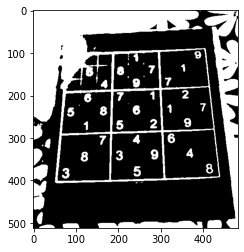

In [3]:
sudoku_color_copy = sudoku_color.copy()
sudoku_blur = cv2.GaussianBlur(sudoku_gray, (7,7), 0)
ret, th = cv2.threshold(sudoku_blur, 170, 255, cv2.THRESH_BINARY_INV)
plt.imshow(th, cmap="gray");

In [4]:
def find_puzzle(image):
	# convert the image to grayscale and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 3)

    # apply adaptive thresholding and then invert the threshold map

    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    thresh = cv2.bitwise_not(thresh)

    # find contours in the thresholded image and sort them by size in
	# descending order
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
	# initialize a contour that corresponds to the puzzle outline
    puzzleContour = None
	# loop over the contours
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # if the approximated contour has four points, then we can
        # assume we have found the outline of the puzzle
        if len(approx) == 4:
            puzzleContour = approx
            break
        
    # if the puzzle contour is empty then the script could not find
    # the outline of the Sudoku puzzle so raise an error
    if puzzleContour is None:
        raise Exception(("Could not find Sudoku puzzle outline."))

    # apply a four point perspective transform to both the original
    # image and grayscale image to obtain a top-down bird's eye view
    # of the puzzle
    puzzle = four_point_transform(image, puzzleContour.reshape(4, 2))
    warped = four_point_transform(gray, puzzleContour.reshape(4, 2))

    return puzzle, warped 


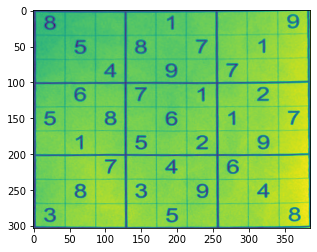

In [5]:
temp_gray, temp_gray_warped = find_puzzle(sudoku)
plt.imshow(temp_gray_warped);

In [10]:
def get_contour_x_center_coordinate(contours):    
    if cv2.contourArea(contours) > 2:
        M = cv2.moments(contours)
    return (int(M['m10']/M['m00']))

In [6]:
def detect_digit(cell):
    th_cell = cv2.threshold(cell, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    th_cell = clear_border(th_cell)

    # find contours in the thresholded cell
    contours = cv2.findContours(th_cell.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)

    # if no contours were found than this is an empty cell
    if len(contours) == 0:
        return None

    # otherwise, find the largest contour in the cell and create a
    # mask for the contour
    main_cell_contour = max(contours, key=cv2.contourArea)
    background = np.zeros(th_cell.shape, dtype="uint8")
    cv2.drawContours(background, [main_cell_contour], -1, 255, -1)

    # compute the percentage of masked pixels relative to the total
    # area of the image
    (h, w) = th_cell.shape
    percentFilled = cv2.countNonZero(background) / float(w * h)
    # if less than 3% of the mask is filled then we are looking at
    # noise and can safely ignore the contour
    if percentFilled < 0.03:
        return None
    # apply the mask to the thresholded cell
    digit = cv2.bitwise_and(th_cell, th_cell, mask=background)

    return digit

In [8]:
original_sudoku, sudoku_cropped = find_puzzle(sudoku)

stepX = sudoku_cropped.shape[1] // 9
stepY = sudoku_cropped.shape[0] // 9

board = np.zeros((9, 9), dtype="int")

cell_locations = []
idx = 0
# loop over the grid locations
for y in range(0, 9):
# initialize the current list of cell locations
    row = []
    for x in range(0, 9):
        idx +=1
        # compute the starting and ending (x, y)-coordinates of the
        # current cell
        leftX = x * stepX
        topY = y * stepY
        rightX = (x + 1) * stepX
        bottomY = (y + 1) * stepY
        # add the (x, y)-coordinates to our cell locations list
        row.append((leftX, topY, rightX, bottomY))

        cell = sudoku_cropped[topY:bottomY, leftX:rightX]

        digit = detect_digit(cell)

        if digit is not None:
            #dilate = cv2.dilate(digit, (3,3), iterations=1)
            sharpening_kernel = np.ones((3,3), np.float32) * -1
            sharpening_kernel[1,1] = 9
            sharp_img = cv2.filter2D(digit, -1, sharpening_kernel)
            
            #cv2.imwrite("./img/export/" + str(idx) + ".png", sharp_img)
            
            # resize
            digit_sm = cv2.resize(sharp_img, (28, 28))

            cv2.imwrite("./img/export/" + str(idx) + ".png", digit_sm)

            # reshape 
            digit_reshaped = digit_sm.reshape(1,28,28,1)
            test_image = (digit_reshaped[...,::-1].astype(np.float32)) / 255.0

            # load trained keras model
            model = load_model('./model/')
            # classify the number 
            preds = model.predict(test_image)
            label = np.argmax(preds, axis=1) 
            board[y, x] = label

    cell_locations.append(row)

In [9]:
board

array([[8, 0, 0, 0, 7, 0, 0, 0, 8],
       [0, 5, 0, 8, 0, 7, 0, 7, 0],
       [0, 0, 2, 0, 8, 0, 7, 0, 0],
       [0, 8, 0, 7, 0, 7, 0, 2, 0],
       [5, 0, 8, 0, 8, 0, 7, 0, 7],
       [0, 9, 0, 5, 0, 2, 0, 8, 0],
       [0, 0, 7, 0, 1, 0, 8, 0, 0],
       [0, 8, 0, 3, 0, 6, 0, 1, 0],
       [3, 0, 0, 0, 5, 0, 0, 0, 8]])

In [46]:
board[4][0] = 4
board[7][3] = 4
board

array([[5, 3, 0, 0, 7, 0, 0, 0, 0],
       [6, 0, 0, 1, 9, 5, 0, 0, 0],
       [0, 9, 8, 0, 0, 0, 0, 6, 0],
       [8, 0, 0, 0, 6, 0, 0, 0, 3],
       [4, 0, 0, 8, 0, 3, 0, 0, 1],
       [7, 0, 0, 0, 2, 0, 0, 0, 6],
       [0, 6, 0, 0, 0, 0, 2, 8, 0],
       [0, 0, 0, 4, 1, 9, 0, 0, 5],
       [0, 0, 0, 0, 8, 0, 0, 7, 9]])

In [47]:
def findNextCellToFill(grid, i, j):
        for x in range(i,9):
                for y in range(j,9):
                        if grid[x][y] == 0:
                                return x,y
        for x in range(0,9):
                for y in range(0,9):
                        if grid[x][y] == 0:
                                return x,y
        return -1,-1

def isValid(grid, i, j, e):
        rowOk = all([e != grid[i][x] for x in range(9)])
        if rowOk:
                columnOk = all([e != grid[x][j] for x in range(9)])
                if columnOk:
                        # finding the top left x,y co-ordinates of the section containing the i,j cell
                        secTopX, secTopY = 3 *(i//3), 3 *(j//3) #floored quotient should be used here. 
                        for x in range(secTopX, secTopX+3):
                                for y in range(secTopY, secTopY+3):
                                        if grid[x][y] == e:
                                                return False
                        return True
        return False

def solveSudoku(grid, i=0, j=0):
        i,j = findNextCellToFill(grid, i, j)
        if i == -1:
                return True
        for e in range(1,10):
                if isValid(grid,i,j,e):
                        grid[i][j] = e
                        if solveSudoku(grid, i, j):
                                return True
                        # Undo the current cell for backtracking
                        grid[i][j] = 0
        return False

In [48]:
solveSudoku(board)

True

In [49]:
board

array([[5, 3, 4, 6, 7, 8, 9, 1, 2],
       [6, 7, 2, 1, 9, 5, 3, 4, 8],
       [1, 9, 8, 3, 4, 2, 5, 6, 7],
       [8, 5, 9, 7, 6, 1, 4, 2, 3],
       [4, 2, 6, 8, 5, 3, 7, 9, 1],
       [7, 1, 3, 9, 2, 4, 8, 5, 6],
       [9, 6, 1, 5, 3, 7, 2, 8, 4],
       [2, 8, 7, 4, 1, 9, 6, 3, 5],
       [3, 4, 5, 2, 8, 6, 1, 7, 9]])

In [50]:
board[1][1]

7

In [51]:
print(cell_locations)

[[(0, 0, 22, 22), (22, 0, 44, 22), (44, 0, 66, 22), (66, 0, 88, 22), (88, 0, 110, 22), (110, 0, 132, 22), (132, 0, 154, 22), (154, 0, 176, 22), (176, 0, 198, 22)], [(0, 22, 22, 44), (22, 22, 44, 44), (44, 22, 66, 44), (66, 22, 88, 44), (88, 22, 110, 44), (110, 22, 132, 44), (132, 22, 154, 44), (154, 22, 176, 44), (176, 22, 198, 44)], [(0, 44, 22, 66), (22, 44, 44, 66), (44, 44, 66, 66), (66, 44, 88, 66), (88, 44, 110, 66), (110, 44, 132, 66), (132, 44, 154, 66), (154, 44, 176, 66), (176, 44, 198, 66)], [(0, 66, 22, 88), (22, 66, 44, 88), (44, 66, 66, 88), (66, 66, 88, 88), (88, 66, 110, 88), (110, 66, 132, 88), (132, 66, 154, 88), (154, 66, 176, 88), (176, 66, 198, 88)], [(0, 88, 22, 110), (22, 88, 44, 110), (44, 88, 66, 110), (66, 88, 88, 110), (88, 88, 110, 110), (110, 88, 132, 110), (132, 88, 154, 110), (154, 88, 176, 110), (176, 88, 198, 110)], [(0, 110, 22, 132), (22, 110, 44, 132), (44, 110, 66, 132), (66, 110, 88, 132), (88, 110, 110, 132), (110, 110, 132, 132), (132, 110, 154, 

[(0, 0, 22, 22), (22, 0, 44, 22), (44, 0, 66, 22), (66, 0, 88, 22), (88, 0, 110, 22), (110, 0, 132, 22), (132, 0, 154, 22), (154, 0, 176, 22), (176, 0, 198, 22)]
[(0, 22, 22, 44), (22, 22, 44, 44), (44, 22, 66, 44), (66, 22, 88, 44), (88, 22, 110, 44), (110, 22, 132, 44), (132, 22, 154, 44), (154, 22, 176, 44), (176, 22, 198, 44)]
[(0, 44, 22, 66), (22, 44, 44, 66), (44, 44, 66, 66), (66, 44, 88, 66), (88, 44, 110, 66), (110, 44, 132, 66), (132, 44, 154, 66), (154, 44, 176, 66), (176, 44, 198, 66)]
[(0, 66, 22, 88), (22, 66, 44, 88), (44, 66, 66, 88), (66, 66, 88, 88), (88, 66, 110, 88), (110, 66, 132, 88), (132, 66, 154, 88), (154, 66, 176, 88), (176, 66, 198, 88)]
[(0, 88, 22, 110), (22, 88, 44, 110), (44, 88, 66, 110), (66, 88, 88, 110), (88, 88, 110, 110), (110, 88, 132, 110), (132, 88, 154, 110), (154, 88, 176, 110), (176, 88, 198, 110)]
[(0, 110, 22, 132), (22, 110, 44, 132), (44, 110, 66, 132), (66, 110, 88, 132), (88, 110, 110, 132), (110, 110, 132, 132), (132, 110, 154, 132), 

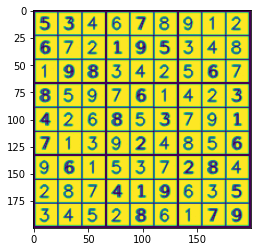

In [53]:
plt.imshow(temp_gray)

In [4]:
def crop_sudoku(sudoku):
    sudoku_gray = cv2.cvtColor(sudoku, cv2.COLOR_BGR2GRAY)
    sudoku_blur = cv2.GaussianBlur(sudoku_gray, (7,7), 0)
    th_sudoku = cv2.threshold(sudoku_blur, 140, 255, cv2.THRESH_BINARY_INV)[1]
    # Find contour and sort by contour area
    cnts = cv2.findContours(th_sudoku, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    # Find bounding box and extract ROI
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        ROI = sudoku_gray[y:y+h, x:x+w]

    return ROI